In [351]:
import os, sys
%pylab inline
import pandas as pd
plt.style.use("default")
plt.rcParams["figure.figsize"]=(8,5)
from importlib import reload
import inputs, classifiers, run
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

Populating the interactive namespace from numpy and matplotlib


In [350]:
import inputs, classifiers, run
reload(classifiers)
reload(run)
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

In [91]:
def load_results(pairs, whiskers, window_size, clf):
    name = f"full_100x_{pairs}_{int(window_size*1000)}ms_W{whiskers}"
    print(f"{name=}")
    config = {"output_prefix":"", "raw":False, "mock":"null", "classifier":clf}
    output_dir = run.get_output_folder_name(config, head = f"data/sweeps/{name}")
    print(output_dir)
    df = pd.concat([pd.read_csv(f) for f in os.scandir(output_dir) if f.is_file() and f.name.endswith(".csv")])
    print(f"Found {len(df)} records.")
    col_names = list(df.columns)
    print(f"Columns: {col_names}")
    df.head()
    print(f"Accuracy at 3 sec. using all ROIs at 2 Hz: ")
    print(mean(df[(df.start_time == 3) & (df.shuf == 0) & (df.n_sub==145) & (df.freq==2)]["test_score"]))
    # Set a flag for whether this was a shuffle run or not.
    df.loc[df.shuf>0, "shuf"]=1
    df2 = df.groupby(['n_sub','shuf','freq','start_time'], as_index=False).agg({'train_score':['mean', 'std'], 'test_score':['mean', 'std']})
    df2.columns = [c  + ("_" if len(d) else "") + d for (c,d) in df2.columns.to_flat_index()]
    return df2

In [382]:
def get_best_coefs(config, clf):
    X, y, t, X_sub, ind_glom = inputs.generate_input_for_config(config, return_full = True)
    search, _   = run.get_pipeline(classifier=clf, return_pipe=True)
    search.fit(X,y)
    best_coefs = search.best_estimator_["clf"].coef_
    return best_coefs

In [383]:
freq_cols = {
    (0,2): "blue", (1,2):"blue",
    (0,20):"red", (1,20):"red",
}
corr_cols = {"corr":"red",
             "acorr":"plum"}

def plot_results(df2, start_time=3, do_plot = True):
    df_sub  = {(sh,freq):df2[(df2.start_time == start_time) & (df2.freq==freq) & (df2.shuf==sh)].sort_values(by=["n_sub"]) for sh in [0,1] for freq in [2,20]}
    h,xx,yy,ss = [],{},{},{}
    for (sh,freq),col in sorted(freq_cols.items()):
        x = df_sub[sh,freq]["n_sub"].values
        ym= df_sub[sh,freq]["test_score_mean"]
        ys= df_sub[sh,freq]["test_score_std"]
        if do_plot:
            fill_between(x, ym-ys, ym+ys, color=list(mcolors.to_rgb(col)) + [0.2])    
            h.append(plot(x,ym,"--" if sh else "-", color=col, label=f"{freq}Hz " + ("sh" if sh else "")))
        else:
            xx[sh,freq] = copy(x)
            yy[sh,freq] = copy(ym)
            ss[sh,freq] = copy(ys)
    if do_plot:
        xlim(x[0],x[-1]); ylim(0.3,1)
    return h if do_plot else (xx,yy,ss)

# Decoding at 20 Hz

In [390]:
whiskers = "both"
window_size = 2
start_time = 3
clf  = "lasso_lars_no_intercept"
dfEF = load_results("EF", whiskers, window_size, clf)
dfAB = load_results("AB", whiskers, window_size, clf)

name='full_100x_EF_2000ms_Wboth'
data/sweeps/full_100x_EF_2000ms_Wboth/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.8273999999999999
name='full_100x_AB_2000ms_Wboth'
data/sweeps/full_100x_AB_2000ms_Wboth/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.6297999999999999


In [389]:
inputs.logger.setLevel(logging.DEBUG)
configAB = inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs="AB", whiskers=whiskers, start_time = start_time)
best_coefs = get_best_coefs(configAB, clf)

DEBUG:inputs:Generating input for Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='both', window_size=2, start_time=3)


DEBUG:inputs:Using pairs=['AB'].


DEBUG:inputs:Picked config.n_sub=145/n_glom=145 glomeruli: ind_glom=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


DEBUG:inputs:Picked time indices 93 (3.010 sec.) to 154 (4.984 sec.) to span [config.start_time=3, end_time=5).


DEBUG:inputs:Shape of predictors: X.shape=(48, 145)


DEBUG:inputs:(stim='20Hzanti-corr01', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzanti-corr02', pair='AB') -> [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


DEBUG:inputs:(stim='20Hzcorr01', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:(stim='20Hzcorr02', pair='AB') -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


DEBUG:inputs:Labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


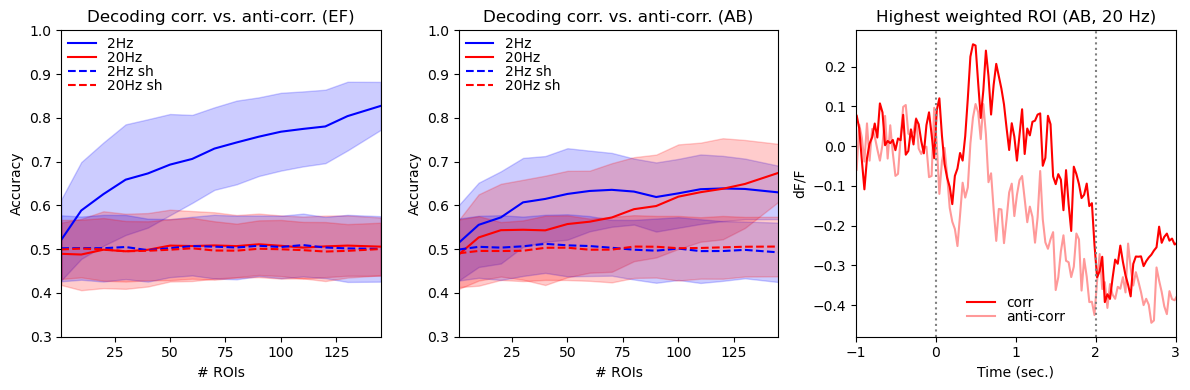

In [324]:
figure(figsize=(12,4))
subplot(1,3,1); hEF = plot_results(dfEF, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (EF)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(1,3,2); hAB = plot_results(dfAB, start_time); xlabel("# ROIs"); ylabel("Accuracy"); title("Decoding corr. vs. anti-corr. (AB)")
legend(frameon=False, labelspacing=0,loc="upper left", fontsize=10, borderpad=0)
subplot(1,3,3)
plot(t-3, mean(X_sub[y>0],axis=0)[argmax(best_coefs)], color=corr_cols["corr"], label="corr")
plot(t-3, mean(X_sub[y<0],axis=0)[argmax(best_coefs)], color=list(mcolors.to_rgb(corr_cols["corr"]))+[0.4], label="anti-corr")
legend(frameon=False, fontsize=10, loc="lower center", labelspacing=0)
yl = ylim(); plot([0,0],yl, ":",color="gray"); plot([2,2],yl, ":",color="gray"); ylim(yl)
title("Highest weighted ROI (AB, 20 Hz)")
xlabel("Time (sec.)"); ylabel("dF/F");
xlim(-1,3)
tight_layout()

# Effect of Whiskers

In [329]:
window_size = 2
start_time = 3
clf  = "lasso_lars_no_intercept"
df_whis = {(pair, whis):load_results(pair, whis, window_size, clf) for pair in ["AB", "CD", "EF"] for whis in ["yes","no"]}
xys = {k:plot_results(df, start_time = 3, do_plot = False) for k, df in df_whis.items()}

name='full_100x_AB_2000ms_Wyes'
data/sweeps/full_100x_AB_2000ms_Wyes/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.7433333333333334
name='full_100x_AB_2000ms_Wno'
data/sweeps/full_100x_AB_2000ms_Wno/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.5793333333333333
name='full_100x_CD_2000ms_Wyes'
data/sweeps/full_100x_CD_2000ms_Wyes/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.8326666666666667
name='full_100x_CD_2000ms_Wno'
data/sweeps/full_100x_CD_2000ms_Wno/lasso_lars_no_intercept


Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.45399999999999996
name='full_100x_EF_2000ms_Wyes'
data/sweeps/full_100x_EF_2000ms_Wyes/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.844333333333333
name='full_100x_EF_2000ms_Wno'
data/sweeps/full_100x_EF_2000ms_Wno/lasso_lars_no_intercept
Found 60000 records.
Columns: ['seed', 'n_sub', 'shuf', 'freq', 'pairs', 'whiskers', 'window_size', 'start_time', 'train_score', 'test_score']
Accuracy at 3 sec. using all ROIs at 2 Hz: 
0.7506666666666666


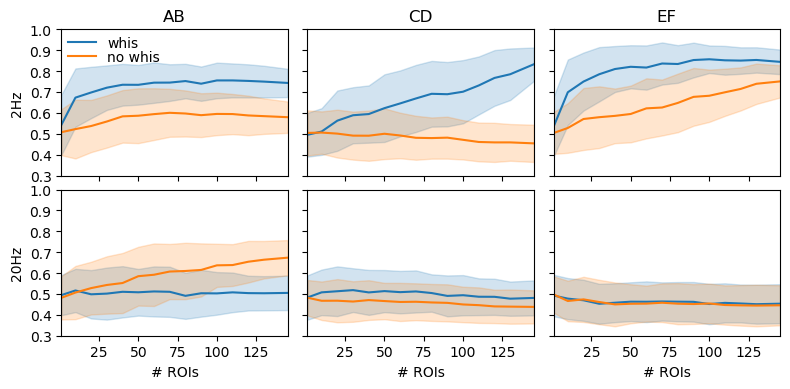

In [377]:
whis_cols = {"yes":"C0", "no":"C1"}
show_shuf = False
sh_freq = [(0,2),(0,20)] + ([(1,2),(1,20)] if show_shuf else [])
min_xlabs = True
min_ylabs = True
figure(figsize=(8,4 + (show_shuf)*4))
gs = GridSpec(4 if show_shuf else 2, 3)
ax = {}
for ip, pair in enumerate(["AB", "CD","EF"]):
    for whis in ["yes","no"]:
        xx,yy,ss = xys[(pair, whis)]
        for isf, (sh, freq) in enumerate(sh_freq):
            ax[isf,ip] = subplot(gs[isf,ip]) if (isf,ip) not in ax else ax[isf,ip]
            ax[isf,ip].fill_between(xx[(sh,freq)], yy[(sh,freq)] - ss[(sh,freq)],  yy[(sh,freq)] + ss[(sh,freq)], color=list(mcolors.to_rgb(whis_cols[whis]))+[0.2])            
            ax[isf,ip].plot(xx[(sh,freq)], yy[(sh,freq)], color=whis_cols[whis], label="whis" if whis == "yes" else "no whis")
            
for ip, pair in enumerate(["AB", "CD", "EF"]):
    for isf, (sh, freq) in enumerate(sh_freq):
        ax[isf,ip].set_ylim(0.3,1)
        ax[isf,ip].set_xticks(arange(0,150,25))
        ax[isf,ip].set_yticks(arange(0.3,1.01,0.1))
        (isf != 3) and (isf != len(sh_freq)-1) and min_xlabs and ax[isf,ip].set_xticklabels([])
        (ip  != 0) and min_ylabs and ax[isf,ip].set_yticklabels([])    
        (ip  == 0) and ax[isf,ip].set_ylabel(f"{freq}Hz" + (" (sh) " if sh else ""))
        (isf == 0) and ax[isf,ip].set_title(pair)
        (isf == len(sh_freq)-1) and ax[isf,ip].set_xlabel("# ROIs")
        ax[isf,ip].set_xlim(xx[0,20][0],xx[0,20][-1])
ax[0,0].legend(loc="upper left", frameon=False, fontsize=10, labelspacing=0, borderpad=0)
tight_layout(h_pad=0)

In [459]:
inputs.logger.setLevel(logging.INFO)
freq = 2; window_size = 2; start_time = 3;
pair_freqs = [("AB", 20), ("CD", 2)]
configs = {(pair, freq, whis):inputs.Config(seed=0,shuf=0, window_size = window_size, n_sub = 145, freq=freq, pairs=pair, whiskers=whis, start_time = start_time) for whis in ["yes","no"] for (pair, freq) in pair_freqs}
best_coefs = {k:get_best_coefs(config, clf) for k,config in configs.items()}
XY = {k:inputs.generate_input_for_config(config, return_full = True) for k,config in configs.items()}

0.34656708902755834


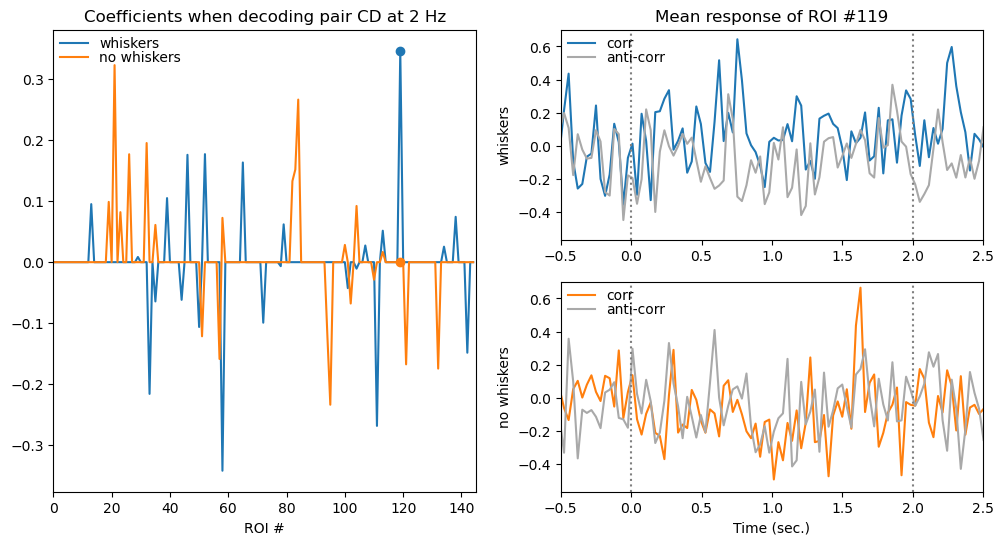

In [483]:
# Find the best coefs of CD at 2 Hz with whiskers
gs = GridSpec(2,2)
key = ("CD", 2, "yes")
#key = ("AB", 20, "yes")
key_no = (key[0], key[1], "no")
coefs = best_coefs[key]
coefs_no = best_coefs[key_no]
order = argsort(coefs)
which_coef = order[-1]

figure(figsize=(12,6));
subplot(gs[:,0]); plot(coefs,label="whiskers"); plot(coefs_no, label="no whiskers");
plot(which_coef, coefs[which_coef],    "o", color="C0")
plot(which_coef, coefs_no[which_coef], "o", color="C1")
legend(frameon=False, labelspacing=0, borderpad=0, fontsize=10)
xlim(0,len(coefs))
title(f"Coefficients when decoding pair {key[0]} at {key[1]} Hz")
xlabel("ROI #")
print(coefs[which_coef])
yl = []
for iw, whis in enumerate(["yes", "no"]):
    subplot(gs[iw,1])
    X,y,t,X_sub,ind_glom = data["CD",2,whis]
    plot(t-3, mean(X_sub[y>0],axis=0)[which_coef], "C0" if whis=="yes" else "C1", label = "corr")
    plot(t-3, mean(X_sub[y<0],axis=0)[which_coef], "darkgray", label = "anti-corr")
    yl = ylim() if not yl else yl
    [plot([t,t],yl, ":", color="gray") for t in [0,2]]
    ylim(yl)
    (iw == 0) and title(f"Mean response of ROI #{which_coef}")
    legend(frameon=False, labelspacing=0, borderpad=0, fontsize=10, loc = "upper left")
    (iw == 1) and xlabel("Time (sec.)")
    ylabel(f"{'whiskers' if whis=='yes' else 'no whiskers'}")
    xlim(-0.5,2.5)


# 

# Miscellaneous

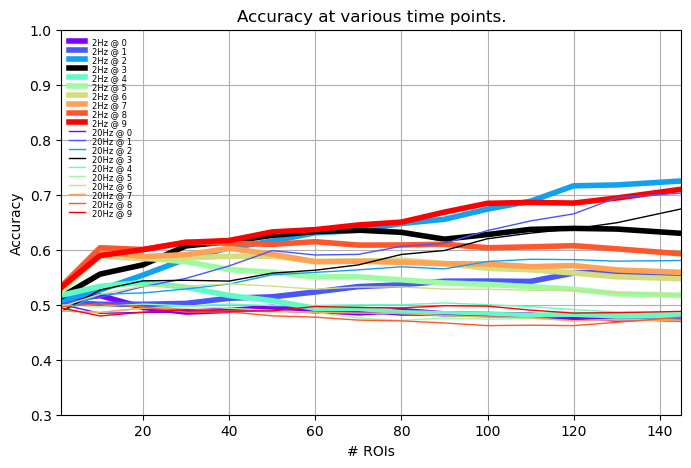

In [77]:
df_sub  = {(freq,t):df2[(df2.start_time == t) & (df2.freq==freq) & (df2.shuf==0)].sort_values(by=["n_sub"]) for t in range(0,10,1) for freq in [2,20]}
figure(figsize=(8,5))
for (freq,t) in sorted(df_sub):
    col = "k" if t==3 else cm.rainbow(t/9.)# if freq==2 else cm.rainbow(t/10.)
    x = df_sub[freq,t]["n_sub"].values
    ym= df_sub[freq,t]["test_score_mean"]
    plot(x,ym,color=col, label=f"{freq}Hz @ {t}", linewidth = 4 if freq==2 else 1)
ylim(0.3,1)
legend(fontsize=6,frameon=False,loc="upper left", labelspacing=0)
xlim(x[0],x[-1])
xlabel("# ROIs")
ylabel("Accuracy")
title(f"Accuracy at various time points.", fontsize=12)
grid(True)

In [103]:
freq = 20
config = inputs.Config(seed=0,
                       shuf=0,
                       window_size = window_size,
                       n_sub = 145,                       
                       freq=freq,
                       pairs="AB", 
                       whiskers=whiskers,
                       start_time = start_time)
print(config)
X, y, t, X_sub, ind_glom = inputs.generate_input_for_config(config, return_full = True)
search, _   = run.get_pipeline(classifier=clf, return_pipe=True)
search.fit(X,y)

Config(seed=0, n_sub=145, shuf=0, freq=20, pairs='AB', whiskers='both', window_size=2, start_time=3)
